<a href="https://colab.research.google.com/github/oakeshott/24PBLA19-1/blob/master/jupyter/sptp-based-ilp/csptp_based_sfc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CSPTP-based ILP for SFC

In [ ]:
!pip install pulp networkx matplotlib pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
!git clone https://github.com/oakeshott/24PBLA19-1

Cloning into '24PBLA19-1'...
remote: Enumerating objects: 157, done.
remote: Counting objects: 100% (157/157), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 157 (delta 103), reused 157 (delta 103), pack-reused 0
Receiving objects: 100% (157/157), 10.46 MiB | 8.83 MiB/s, done.
Resolving deltas: 100% (103/103), done.
Updating files: 100% (136/136), done.


In [ ]:
import pulp
import networkx as nx
import os
import matplotlib.pyplot as plt
import json
import time
import pandas as pd

# How to use Pulp and Networkx

## Shortest Path Problem Formulation

- Inputs:
    * Directed graph $G=(\mathcal{V}, \mathcal{E})$, source $s$, and destination $d$
    * Distance $d_{i,j}$ of link $(i,j) \in \mathcal{E}$
    * Decision variables $\mathbf{x}=[x_{i,j}]$, $((i,j)\in\mathcal{E})$  
        * If $x_{i,j}=1$, the link $(i,j)$ is used.
        * Otherwise, the link $(i,j)$ is not used.
    * If $i = s$, the node $i$ is a supply point (i.e, $i=1$)
    * If $i = d$, the node $i$ is a demand point (i.e, $i=-1$)
    * Otherwise, the node $i$ is a passing point (i.e., $i=0$)
    * $\mathcal{V}_i$: A set of neighbors of node $i$
- Output: The shortest path distance
- Objective funciton: Minimize the path distance
$$
\min \sum_{(i,j) \in \mathcal{E}} d_{i,j}x_{i,j}
$$
- Constraints
$$
\begin{align}
\mathrm{s.t.} &\quad x_{i,j} = \{0, 1\} \quad (i,j) \in \mathcal{E}\\
&\quad\sum_{j \in \mathcal{V_i}} x_{i,j} - \sum_{j \in \mathcal{V_i}} x_{j,i} = \begin{cases}
1 \quad &\textrm{if $i == s$,}\\
-1 \quad &\textrm{if $i == d$,}\\
0 \quad &\textrm{otherwise.}\\
\end{cases} i \in \mathcal{V}
\end{align}
$$

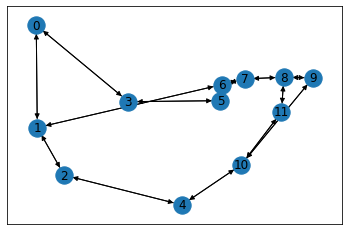

In [ ]:
basedir = "/content/22PBLA18-1/"
path = os.path.join(basedir, "dataset/nsfnetbw")
filename = os.path.join(path, "network.gml")
G = nx.read_gml(filename, label="id")
pos = {n: (G.nodes()[n]["lng"], G.nodes()[n]["lat"]) for n in G.nodes()}
nx.draw_networkx(G, pos=pos)

In [ ]:
print("Data fowarding delay", nx.get_node_attributes(G, "delay"))
print("Propagation delay", nx.get_edge_attributes(G, "delay"))
print("Processing capacity", nx.get_node_attributes(G, "capacity"))
print("Bandwidth", nx.get_edge_attributes(G, "bandwidth"))

Data fowarding delay {0: 0.1, 1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1, 5: 0.1, 6: 0.1, 7: 0.1, 8: 0.1, 9: 0.1, 10: 0.1, 11: 0.1}
Propagation delay {(0, 1): 10.0, (0, 3): 10.0, (1, 0): 10.0, (1, 2): 10.0, (1, 6): 10.0, (2, 1): 10.0, (2, 4): 10.0, (3, 0): 10.0, (3, 5): 10.0, (4, 2): 10.0, (4, 10): 10.0, (5, 3): 10.0, (5, 6): 10.0, (6, 1): 10.0, (6, 5): 10.0, (6, 7): 10.0, (7, 8): 10.0, (7, 6): 10.0, (8, 9): 10.0, (8, 11): 10.0, (8, 7): 10.0, (9, 8): 10.0, (9, 10): 10.0, (10, 9): 10.0, (10, 11): 10.0, (10, 4): 10.0, (11, 8): 10.0, (11, 10): 10.0}
Processing capacity {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0}
Bandwidth {(0, 1): 1000.0, (0, 3): 1000.0, (1, 0): 1000.0, (1, 2): 1000.0, (1, 6): 1000.0, (2, 1): 1000.0, (2, 4): 1000.0, (3, 0): 1000.0, (3, 5): 1000.0, (4, 2): 1000.0, (4, 10): 1000.0, (5, 3): 1000.0, (5, 6): 1000.0, (6, 1): 1000.0, (6, 5): 1000.0, (6, 7): 1000.0, (7, 8): 1000.0, (7, 6): 1000.0, (8, 9): 1000.0, (8, 11): 1000.0, (8, 7):

In [ ]:
# define source and destination
source = 0
destination = 11
# define shortst path problem
problem = pulp.LpProblem("Shortest path problem", pulp.LpMinimize)

# define binary decision variables
x = {}
for i, j in G.edges():
  x[i,j] = pulp.LpVariable(f"x_{i},{j}", 0, 1, pulp.LpBinary)

# define objective function
problem += pulp.lpSum(G[i][j]["delay"] * x[i,j] for i, j in G.edges())

# define constraints
for i in G.nodes():
  if i == source:
    problem += pulp.lpSum(x[i,j] for j in G.neighbors(i)) - pulp.lpSum(x[j,i] for j in G.neighbors(i)) == 1, f"flow_constraint_node_{i}"
  elif i == destination:
    problem += pulp.lpSum(x[i,j] for j in G.neighbors(i)) - pulp.lpSum(x[j,i] for j in G.neighbors(i)) == -1, f"flow_constraint_node_{i}"
  else:
    problem += pulp.lpSum(x[i,j] for j in G.neighbors(i)) - pulp.lpSum(x[j,i] for j in G.neighbors(i)) == 0, f"flow_constraint_node_{i}"
print(problem)

Shortest_path_problem:
MINIMIZE
10.0*x_0,1 + 10.0*x_0,3 + 10.0*x_1,0 + 10.0*x_1,2 + 10.0*x_1,6 + 10.0*x_10,11 + 10.0*x_10,4 + 10.0*x_10,9 + 10.0*x_11,10 + 10.0*x_11,8 + 10.0*x_2,1 + 10.0*x_2,4 + 10.0*x_3,0 + 10.0*x_3,5 + 10.0*x_4,10 + 10.0*x_4,2 + 10.0*x_5,3 + 10.0*x_5,6 + 10.0*x_6,1 + 10.0*x_6,5 + 10.0*x_6,7 + 10.0*x_7,6 + 10.0*x_7,8 + 10.0*x_8,11 + 10.0*x_8,7 + 10.0*x_8,9 + 10.0*x_9,10 + 10.0*x_9,8 + 0.0
SUBJECT TO
flow_constraint_node_0: x_0,1 + x_0,3 - x_1,0 - x_3,0 = 1

flow_constraint_node_1: - x_0,1 + x_1,0 + x_1,2 + x_1,6 - x_2,1 - x_6,1 = 0

flow_constraint_node_2: - x_1,2 + x_2,1 + x_2,4 - x_4,2 = 0

flow_constraint_node_3: - x_0,3 + x_3,0 + x_3,5 - x_5,3 = 0

flow_constraint_node_4: - x_10,4 - x_2,4 + x_4,10 + x_4,2 = 0

flow_constraint_node_5: - x_3,5 + x_5,3 + x_5,6 - x_6,5 = 0

flow_constraint_node_6: - x_1,6 - x_5,6 + x_6,1 + x_6,5 + x_6,7 - x_7,6 = 0

flow_constraint_node_7: - x_6,7 + x_7,6 + x_7,8 - x_8,7 = 0

flow_constraint_node_8: - x_11,8 - x_7,8 + x_8,11 + x_8,7 +

/usr/local/lib/python3.7/dist-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [ ]:
status = problem.solve()
print(f"Status: {pulp.LpStatus[status]}, Objective value: {pulp.value(problem.objective)}")
for i, j in G.edges():
  value = pulp.value(x[i,j])
  if value == 1:
    print(f"{i}\t{j}\t{value}")

Status: Optimal, Objective value: 50.0
0	1	1.0
1	6	1.0
6	7	1.0
7	8	1.0
8	11	1.0


In [ ]:
shortest_path_length = nx.shortest_path_length(G, source, destination, weight="delay")
print(f"Shortest path length: {shortest_path_length}")
# We observe that the ILP exhibts the same result as the shortest path selection.

Shortest path length: 50.0


# Network Functions Virtualization and Service Chaining
## Network Fucntions Virtualization (NFV)
- The NFV network decuples the network functions from the dedicated hardware and then execute them on the generic hardware as the virtual network functions (VNFs).
  * Network function: e.g., NAT, firewall.
- The NFV network can deploy agile and flexible network services.
  * Network service: e.g, video streaming, web service
- A certain network service can be interpreted as a sequence of VNFs called service chain.
    * In case of video streaming, the network service consists of NAT→FW→TM→VOC→IDPS
        * It is important to ensure the function execution order.
        * NAT: Network Address Translator
        * FW: Firewall
        * TM: Traffic Monitoring
        * VOC: Video Optimization Controller
        * IDPS: Intrusion Detection Prevention System
- The NFV network can deploy network services with agility and flexibility as well as reducing capital expenditure (CAPEX) and operating expenditure (OPEX).

<figure>
<img src="https://raw.githubusercontent.com/oakeshott/21SS_CSPTP-baesed_ILP/master/fig/PNF_vs_VNF.png" width=80%></img>
</figure>

## Service Chaining (SC) Problem
- Given a service chain request (SCR), an NFV orchestrator finds a service path from an origin node to a destination node while executing the VNFs at the intermediate nodes in required order under resource constraints.
- The SC problem belongs to the complexity class NP-hard.

## Shortest path tour problem (SPTP)
- SPTP is a variant of shortest path problem and aims at finding the shortest path from an origin node to a destination node while visiting at least one node from given disjoint node subsets, $\mathcal{T}_1, \ldots, \mathcal{T}_K$ ($\mathcal{T}_1, \cap \ldots \cap \mathcal{T}_K = \emptyset$, in this order
The similarity between SC and SPTP is pointed out


## System Model
### Service Chain Request (SCR)
Each service path request has service chain requirements $r_c$. The NFV orchestrator need to establish a service path while meeting the service chain requirements.
- Service chain requirement $r_c=(o_c, d_c, \mathrm{R}_c, b_c, p_c^{\mathrm{node}}, \{p_{c,f_{c,k}}\}_{k=1,\ldots,K_c})$
  * $o_c$: origin node
  * $d_c$: destination node
  * $\mathrm{R}_c$: A sequence of $K_c$ VNFs $\mathrm{R}_c = (f_{c,1},\ldots,f_{c,K_c+1})$
  * $b_c$: Bit rate required by the SCR $c$
  * $p_c^{\mathrm{node}}$: Processing resources required for data forwarding
  * $p_{c,f_{c,k}}$: Processing resources equired for executing the 𝑘th function $f_{c,k}$ at a physical node.
  * $\mathcal{K}_c = \{1, \ldots, K_c\}$
  * $\mathcal{K}_c^+ = \{1, \ldots, K_c+1\}$

<figure>
<img src="https://raw.githubusercontent.com/oakeshott/21SS_CSPTP-baesed_ILP/master/fig/service_chain_requirements.png" width=50%></img>
  <figcaption>An example of an SCR.</figcaption>
</figure>

### Physical network
A physical network can be expressed by a directed graph $G=(\mathcal{V},\mathcal{E})$.
- $\mathcal{V}$: a set of physical nodes
- $\mathcal{E}$: a set of physical links

Each physical link $(i,j) \in \mathcal{E}$ (resp. each physical node $i \in \mathcal{V}$) has residual bandwidth $B_{i,j}$ (resp. residual processing capacity $P_i$) at the beginning of serving the SCRs $C$.

The NFV network supports $F$ distinct functions, i.e., $F=\{f_1,\ldots,f_F\}$.

<figure>
<img src="https://raw.githubusercontent.com/oakeshott/22PBLA18-1/master/fig/physical_network.png" width=50%></img>
  <figcaption>An example of a physical network</figcaption>
</figure>

### Augmented Network
The augmented network $G^+=(\mathcal{V}^+, \mathcal{E}^+)$ is defined as a physical network $G$ with imaginary nodes $\hat{\mathcal{V}}$ and virtual links $\hat{\mathcal{E}}^\mathrm{in} \cup \hat{\mathcal{E}}^\mathrm{out}$
- $\mathcal{V}^+=\mathcal{V} \cup \hat{\mathcal{V}}$
- $\mathcal{E}^+=\mathcal{E} \cup \hat{\mathcal{E}}^\mathrm{in} \cup \hat{\mathcal{E}}^\mathrm{out}$
- An imaginary node $\hat{v}_{f_{c,k}} \in \hat{\mathcal{V}}$ is responsible for the $k$th function $f_{c,k}$ and is connected to a physical link supporting the fucntion $f_{c,k}$ via a virtual link.
- An incoming virtual link $(v, \hat{v}_{f_{c,k}})$ corresponds to the execution of function $f_{c,k}$ when it is included in a service path.
- $\hat{\mathcal{E}}^\mathrm{in}$ is a set of incoming virtual links to $\hat{v}_f$.
- $\hat{\mathcal{E}}^\mathrm{out}$ is a set of outgoing virtual links from $\hat{v}_f$.
- $\mathcal{V}^+_i$: A set of neighbors of $i \in \mathcal{V}^+$

<figure>
<img src="https://raw.githubusercontent.com/oakeshott/22PBLA18-1/master/fig/augmented_network.png" width=50%></img>
  <figcaption>An example of augmented network</figcaption>
</figure>

### Service Path
The service path with origin $o_c$, destination $d_c$, and $\mathcal{R}_c=(f_{c,1},\ldots,f_{c,K_c})$ is composed of $K_c+1$ subpaths.（$\mathcal{S}_c=(\mathcal{S}_{c,1},\ldots,\mathcal{S}_{c,K_c+1})$).
The pair $(a_k, b_k)$ of origin and destination nodes of the $k$th subpath is given as follows:

$$
(a_{k},b_{k}) =
\begin{cases}
  (o_c, \hat{v}_{f_{c,1}}), & k = 1\\
  (\hat{v}_{f_{c,k-1}}, \hat{v}_{f_{c,k}}),& k = 2,\ldots,K_c\\
  (\hat{v}_{f_{c,K_c}}, d_c), & k = K_c+1
\end{cases}
$$
<figure>
<img src="https://raw.githubusercontent.com/oakeshott/22PBLA18-1/master/fig/service_path.png" width=50%></img>
  <figcaption>An example of service path</figcaption>
</figure>

Total service path delay is defined as the sum of propagation delay and processing delay along the path.
* $d_{i,j}^{\mathrm{link}}$: Propagation delay of physical link $(i,j)$
* $d_v^{\mathrm{node}}$: Procesing delay of physical node $v\in\mathcal{V}$ for data forwarding.
* $d_{\hat{v}_f,v}^{\mathrm{func}}$: Processing delay of physical node $v\in\mathcal{V}$ for executing the function $f$.

The service path has the following characteristics.
- The service path may contain loop(s).
- Each subpath does not contain any loop.
- Every node and link have capacity constraints.


# SPTP-based Service Chaining

## Formulation
- Inputs:
  - Directed Graph $G^+=(\mathcal{V}^+, \mathcal{E}^+)$
  - $r_c=(o_c, d_c, \mathrm{R}_c, b_c, p_c^{\mathrm{node}}, \{p_{c,f_{c,k}}\}_{k=1,\ldots,K_c})$
- Output: Service path $\mathcal{S}_c$
- Objective function: Minimization of total service path delay
$$
  \min \quad \sum_{(i,j) \in \mathcal{E}^{+}} d_{i,j} \sum_{k \in \mathcal{K}_c^{+}} x_{i,j}^{k}.
$$

$d_{i,j}$ is given by
$$
d_{i,j} =     
\begin{cases}
  d_i^{\mathrm{node}} + d_{i,j}^{\mathrm{link}}, & \textrm{if $(i, j) \in \mathcal{E}$,}
\\
  d_{i,j}^{\mathrm{func}}, & \textrm{if $(i, j) \in \hat{\mathcal{E}}^{\mathrm{out}}$,}
\\
  0, & \textrm{Otherwise.}
\end{cases}
$$

If $(i,j) \in \mathcal{E}$, the processing delay for data forwarding and propagation delay are considered.
If $(i,j) \in \hat{\mathcal{E}}^{\mathrm{out}}$, the processing delay for executing the function $f$ are considered.

- Constraints
$$
\begin{align}
\mathrm{s.t.} &\quad x_{i,j}^{k} = \{0,1\}, \quad (i,j) \in \mathcal{E}^+, k \in \mathcal{K}_c^+, &(1)\\
&\sum_{j \in \mathrm{V}_i^+} x_{i,j}^{k} - \sum_{j \in \mathrm{V}_i^+} x_{j,i}^{k} =
\begin{cases}
    1 & \textrm{if $i = a_{k}$,}\\
    -1 & \textrm{if $i = b_{k}$,}\\
    0 & \textrm{otherwise,}\\
\end{cases} i \in \mathcal{V}^+, k \in \mathcal{K}_c^+&(2)\\
&x_{i,\hat{v}_{f_{c,k}}}^{k} = x_{\hat{v}_{f_{c,k}},i}^{k+1} , \quad (i,\hat{v}_{f_{c,k}}) \in \hat{\mathcal{E}}^\mathrm{in}, (\hat{v}_{f_{c,k}},i) \in \hat{\mathcal{E}}^\mathrm{out}, k \in \mathcal{K}_c&(3)\\
&x_{i,\hat{v}_{f_{c,m}}}^{k} = 0, \quad (i,\hat{v}_{f_{c,m}}) \in \hat{\mathcal{E}}^\mathrm{in}, k \in \mathcal{K}_c^{+}, m \neq k&(4)\\
&b_c \sum_{k \in \mathcal{K}_c^{+}} x_{i,j}^{k} \leq B_{i,j}, \quad (i,j) \in \mathcal{E}&(5)\\
&p_c^\mathrm{node} \sum_{(v,j) \in \mathcal{E}} \sum_{k \in \mathcal{K}_c^{+}} x_{v,j}^{k} + \sum_{(\hat{v}_f,v) \in \hat{\mathcal{E}}^\mathrm{out}}p_{c,f}^\mathrm{func} \sum_{k \in \mathcal{K}_c^{+}} x_{\hat{v}_f,v}^{k} \leq P_v, \quad v \in \mathcal{V}.&(6)
\end{align}
$$

SPTP-related constraints are (1)-(4).
Constraint (1) is decision variables.
If $x_{i,j}^{k}=1$, the link $(i,j)$ is used in the $k$ subpath.
Otherwise, the link is not used.
Constraint (2) is the standard flow conservation rules.
Cosntraint (3) ensures the connectivity between the $k$th and $k+1$th subpaths.
Constraint (4) prohibits the unnecessary execution of $m$th function $f_{c,m}$ in the $k$th ($m \neq k$) subpath.
Constraint (5) and (6) give the constraints on physical link capacity and processing capacity of physical node, respectively.

A set of physical nodes [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
A set of physical links [(0, 1), (0, 3), (1, 0), (1, 2), (1, 6), (2, 1), (2, 4), (3, 0), (3, 5), (4, 2), (4, 10), (5, 3), (5, 6), (6, 1), (6, 5), (6, 7), (7, 8), (7, 6), (8, 9), (8, 11), (8, 7), (9, 8), (9, 10), (10, 9), (10, 11), (10, 4), (11, 8), (11, 10)]
$d_{i}^{\mathrm{node}}$ {0: 0.1, 1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1, 5: 0.1, 6: 0.1, 7: 0.1, 8: 0.1, 9: 0.1, 10: 0.1, 11: 0.1}
$d_{i,j}^{\mathrm{link}}$ {(0, 1): 10.0, (0, 3): 10.0, (1, 0): 10.0, (1, 2): 10.0, (1, 6): 10.0, (2, 1): 10.0, (2, 4): 10.0, (3, 0): 10.0, (3, 5): 10.0, (4, 2): 10.0, (4, 10): 10.0, (5, 3): 10.0, (5, 6): 10.0, (6, 1): 10.0, (6, 5): 10.0, (6, 7): 10.0, (7, 8): 10.0, (7, 6): 10.0, (8, 9): 10.0, (8, 11): 10.0, (8, 7): 10.0, (9, 8): 10.0, (9, 10): 10.0, (10, 9): 10.0, (10, 11): 10.0, (10, 4): 10.0, (11, 8): 10.0, (11, 10): 10.0}
$P_i$ {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0}
$B_{i,j}$ {(0, 1): 10

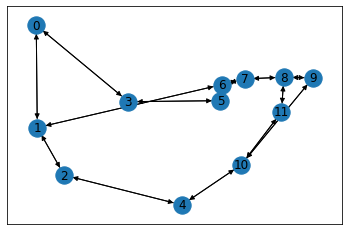

In [ ]:
# Define physical network
path = "/content/22PBLA18-1/dataset/nsfnetbw"
filename = os.path.join(path, "network.gml")
physical_network = nx.read_gml(filename, label="id")
physical_node_size = len(physical_network.nodes())
print("A set of physical nodes", G.nodes())
print("A set of physical links", G.edges())

print(r"$d_{i}^{\mathrm{node}}$", nx.get_node_attributes(G, "delay"))
print(r"$d_{i,j}^{\mathrm{link}}$", nx.get_edge_attributes(G, "delay"))
print(r"$P_i$", nx.get_node_attributes(G, "capacity"))
print(r"$B_{i,j}$", nx.get_edge_attributes(G, "bandwidth"))
pos = {n: (physical_network.nodes()[n]["lng"], physical_network.nodes()[n]["lat"]) for n in physical_network.nodes()}
nx.draw_networkx(physical_network, pos=pos)

In [ ]:
# define service chain requirements
filename = os.path.join(path, "service_chain_requirements.json")
with open(filename) as f:
  connections = json.load(f)
for connection in connections:
  connection['required_processing_func'] = {int(k): v for k, v in connection['required_processing_func'].items()}
connection = connections[0]
"""
{'arrival_time': Arrival time,
'destination': destination node,
'id': SCR ID,
'origin': origin node,
'processing_time': service time,
'request': a sequence of functions, R_c,
'required_bandwidth': b_c,
'required_processing_func': {'0': processing resources for executing function 0, '1': processing resources for executing function 1, '2': processing resources for executing function 2, '3': processing resources for executing function 3, '4': processing resources for executing function 4, '5': processing resources for executing function 5,},
'required_processing_node':processing resources for data forwarding}
"""
print(connection)

{'arrival_time': 0.5396058372591854, 'destination': 10, 'id': 0, 'origin': 8, 'processing_time': 100.0, 'request': [0, 1, 2, 5, 4], 'required_bandwidth': 4.0, 'required_processing_func': {0: 0.00092, 1: 0.0009, 2: 0.0133, 4: 0.0107, 5: 0.0054}, 'required_processing_node': 0.0005}


## Service Chain Requests

Service | Sequence of functions
---|---
Web service | NAT-FW-TM-WOC-IDPS
VoIP | NAT-FW-TM-FW-NAT
Video streaming | NAT-FW-TM-VOC-IDPS
Online gaming | NAT-FW-VOC-WOC-IDPS

## Network functions
- NAT: Network Address Translator, function 0
- FW: Firewall, function 1                                 
- TM: Traffic Monitoring, function 2                       
- IDPS: Intrusion Detection Prevention System, function 3
- VOC: Video Optimization Controller, function 4
- WOC: WAN Optimization Controller, function 5

In [ ]:
filename = os.path.join(path, "function_placement.json")
with open(filename) as f:
  function_placement = json.load(f)
placement = function_placement["placement"]
print(placement)
F = set(function_placement['functions'])
print(r"$\mathcal{F}$", F)
"""
- NAT: Network Address Translator, function 0
- FW: Firewall, function 1
- TM: Traffic Monitoring, function 2
- IDPS: Intrusion Detection Prevention System, function 3
- VOC: Video Optimization Controller, function 4
- WOC: WAN Optimization Controller, function 5
"""

imaginary_links = pd.DataFrame.from_dict(placement)
imaginary_nodes = {f: f+physical_node_size for f in F}
"""
{0: 12, 1: 13, 2: 14, 3: 15, 4: 16, 5: 17}
For example {0: 12} means that the imaginary node id of the network function 0 (NAT) is 12.
We can calculate the function id from the imaginary node id by defining the imaginary node id as the sum of the function id and the number of physical nodes
"""
print("Imaginary node", imaginary_nodes)
"""
    delay  function  physical_node
6      50         3             11
This indicates that the physical node 11 is connected to the imaginary node 14 responsible for function 3 and its processing delay is 50 ms.
"""
print("Virtual links", imaginary_links)

[{'delay': 50, 'function': 0, 'physical_node': 0}, {'delay': 50, 'function': 0, 'physical_node': 2}, {'delay': 50, 'function': 1, 'physical_node': 1}, {'delay': 50, 'function': 1, 'physical_node': 6}, {'delay': 50, 'function': 2, 'physical_node': 4}, {'delay': 50, 'function': 2, 'physical_node': 3}, {'delay': 50, 'function': 3, 'physical_node': 11}, {'delay': 50, 'function': 3, 'physical_node': 5}, {'delay': 50, 'function': 4, 'physical_node': 8}, {'delay': 50, 'function': 4, 'physical_node': 8}, {'delay': 50, 'function': 5, 'physical_node': 7}, {'delay': 50, 'function': 5, 'physical_node': 9}]
$\mathcal{F}$ {0, 1, 2, 3, 4, 5}
Imaginary node {0: 12, 1: 13, 2: 14, 3: 15, 4: 16, 5: 17}
Virtual links     delay  function  physical_node
0      50         0              0
1      50         0              2
2      50         1              1
3      50         1              6
4      50         2              4
5      50         2              3
6      50         3             11
7      50    

A set of nodes of augmented network [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
A set of links of augmented network [(0, 1), (0, 3), (0, 12), (1, 0), (1, 2), (1, 6), (1, 13), (2, 1), (2, 4), (2, 12), (3, 0), (3, 5), (3, 14), (4, 2), (4, 10), (4, 14), (5, 3), (5, 6), (5, 15), (6, 1), (6, 5), (6, 7), (6, 13), (7, 8), (7, 6), (7, 17), (8, 9), (8, 11), (8, 7), (8, 16), (9, 8), (9, 10), (9, 17), (10, 9), (10, 11), (10, 4), (11, 8), (11, 10), (11, 15), (12, 0), (12, 2), (13, 1), (13, 6), (14, 4), (14, 3), (15, 11), (15, 5), (16, 8), (17, 7), (17, 9)]


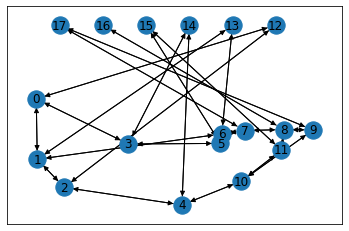

In [ ]:
# define augmented network
G = physical_network.copy()
for func, node in imaginary_nodes.items():
  G.add_node(node, lng=-(func+1)*8 - 70, lat=60, delay=0)
imaginary_links.apply(lambda x: G.add_edge(x.physical_node, imaginary_nodes[x.function], delay=0), axis=1)
imaginary_links.apply(lambda x: G.add_edge(imaginary_nodes[x.function], x.physical_node, delay=x.delay * 1e-3), axis=1) # d_{i,j}^{func}
print("A set of nodes of augmented network", G.nodes())
print("A set of links of augmented network", G.edges())
pos = {n: (G.nodes()[n]["lng"], G.nodes()[n]["lat"]) for n in G.nodes()}
nx.draw_networkx(G, pos=pos)

In [ ]:
# define the origin and destination of k-th subpath
a = []
b = []
for c in connections:
  R_c = c['request']
  K_c = len(R_c)
  o_c = c['origin']
  d_c = c['destination']
  a_ck = []
  b_ck = []
  for k in range(K_c+1):
    if k == 0:
      a_ck.append(o_c)
    if k == K_c:
      b_ck.append(d_c)
    else:
      a_ck.append(imaginary_nodes[R_c[k]])
      b_ck.append(imaginary_nodes[R_c[k]])
  a.append(a_ck)
  b.append(b_ck)
print("a_k =", a[0])
print("b_k =", b[0])

In [ ]:
# formualte ILP
m = pulp.LpProblem("SPTP-based-ILP", pulp.LpMinimize)

# define binary decision variables
x = {}
for c, connection in enumerate(connections):
  K_c = len(connection['request'])
  for k in range(K_c+1):
    for i, j in G.edges():
      x[i,j,c,k] = pulp.LpVariable("x_{:},{:},{:},{:}".format(i, j, c, k), 0, 1, pulp.LpBinary)
      # c means the service chain request
# define objective function
m += pulp.lpSum(G[i][j]["delay"] * pulp.lpSum(x[i,j,c,k]         for c in range(len(connections)) for k in range(len(connections[c]['request'])+1) ) for i, j in physical_network.edges()) \
      + pulp.lpSum(G.nodes()[v]["delay"] * pulp.lpSum(x[v,j,c,k] for c in range(len(connections)) for k in range(len(connections[c]['request'])+1) ) for v, j in physical_network.edges()) \
      + pulp.lpSum(G[v_f][v]["delay"] * pulp.lpSum(x[v_f,v,c,k]  for c in range(len(connections)) for k in range(len(connections[c]['request'])+1) ) for v_f, v in G.edges() if v_f in imaginary_nodes.values()), "Objective function"



In [ ]:
# define constraint (2)
for c, connection in enumerate(connections):
  K_c = len(connection['request'])
  for k in range(K_c + 1):
    for i in G.nodes():
      if i == a[c][k]:
        m += "Fill in the constraints", f"flow_constraint_c{c}_k{k}_i{i}"
      elif i == b[c][k]:
        m += "Fill in the constraints", f"flow_constraint_c{c}_k{k}_i{i}"
      else:
        m += "Fill in the constraints", f"flow_constraint_c{c}_k{k}_i{i}"

In [ ]:
# define constraint (3)
for c, connection in enumerate(connections):
  K_c = len(connection['request'])
  for k in range(K_c):
    v_f_ck = b[c][k]
    for i in G.neighbors(v_f_ck):
      m += "Fill in the constraints", "connectivity_of_subpath_constraint_i{:}j{:}c{:}k{:}".format(i, v_f_ck, c, k)

In [ ]:
# define constraint (4)
for c, connection in enumerate(connections):
  K_c = len(connection['request'])
  for k in range(K_c+1):
    for i, v_f in G.edges():
      if v_f in imaginary_nodes.values() and not v_f is b[c][k]:
        m += x[i, v_f, c, k] == 0, "infeasible_link_i{:}j{:}k{:}c{:}".format(i, v_f, k, c)


In [ ]:
# define constraint (5)
for i, j in physical_network.edges():
  m += pulp.lpSum(connection['required_bandwidth'] * pulp.lpSum(x[i, j, c, k] for k in range(len(connection['request'])+1)) for c, connection in enumerate(connections)) <= physical_network[i][j]["bandwidth"], "physical_link_capacity_i{:}j{:}".format(i, j)
# define constraint (6)
for v in physical_network.nodes():
  m += pulp.lpSum(connection["required_processing_node"] * pulp.lpSum(x[v,j,c,k] for j in physical_network.neighbors(v) for k in range(len(connection['request'])+1)) + \
      pulp.lpSum(connection["required_processing_func"][v_f-physical_node_size] * pulp.lpSum(x[v_f,v,c,k] for k in range(len(connection['request'])+1)) for v_f in G.neighbors(v) if v_f in imaginary_nodes.values() and v_f-physical_node_size in connection['request']) for c, connection in enumerate(connections)) \
  <= physical_network.nodes()[v]["capacity"], "processing_capacity_constraint_v{:}".format(v)
# define additional constraints
for c, connection in enumerate(connections):
  K_c = len(connection['request'])
  o = connection['origin']
  d = connection['destination']
  m += pulp.lpSum(x[i,o,c,0] for i in G.neighbors(o)) == 0, "constraint_7_w{:}".format(c)
  m += pulp.lpSum(x[d,i,c,len(connection['request'])] for i in G.neighbors(d)) == 0, "constraint_8_w{:}".format(c)


In [ ]:
# LP file
m

In [ ]:
# Solve
start = time.perf_counter()
status = m.solve()
end = time.perf_counter()
elapsed = end - start
print(f"Status: {pulp.LpStatus[status]}, Objective value: {pulp.value(m.objective)}, Execution time: {elapsed}")
for c in range(len(connections)):
  K_c = len(connections[c]['request'])
  for k in range(K_c+1):
    for i, j in G.edges():
      value = pulp.value(x[i,j,c,k])
      if value == 1:
        print(f"{i}\t{j}\t{c}\t{k}\t{value}")

In [ ]:
# Display a service path
for c in range(len(connections)):
  K_c = len(connections[c]['request'])
  for k in range(K_c+1):
    for i, j in G.edges():
      G[i][j]["color"] = "k"
    for i, j in G.edges():
      value = pulp.value(x[i,j,c,k])
      if value == 1:
        G[i][j]["color"] = "r"
    colors = list(nx.get_edge_attributes(G, "color").values())
    fig = plt.figure()
    ax = fig.add_subplot(111)
    pos = {n: (G.nodes()[n]["lng"], G.nodes()[n]["lat"]) for n in G.nodes()}
    nx.draw_networkx(G, pos=pos, edge_color=colors, ax=ax)
    ax.set_title(f"$k$={k+1}")

# Task
In terms of the scalability, the students tackles the following tasks by using the ILP for SPTP-based SC.
1. Impact of the number of physical nodes on both the execution time and objective value.
2. Impact of the number of service chain requests on both the execution time and objective value.

As for the task 1, please confirm how the execution time changes as the number of nodes increases, using a group of files from 100 to 1000 nodes as inputs.
The input files can be available at `/content/24PBLA19-1/dataset/nrof_nodes*`.

As for the task 2, please confirm how the execution time changes as the number of service chain requests increases, using a group of files from service chain requests 1 to 10 as inputs.
The input files can be available at `/content/24PBLA19-1/dataset/nrof_connections*`.

Please draw a graph for the results of both tasks by using matplotlib.

## Additional Task (Optional)
You can confirm from the above tasks that the ILP has huge computing resources.
Please consider and design a heuristic algorithm to overcome the computational complexity while keeping the solution optimality.